In [2]:
import numpy as np 
import h5py
import urllib
import os
import matplotlib.pyplot as plt
import urllib.request
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import tqdm

from test_python.kaczmarzReg import *
from test_python.pseudoinverse import *

from MPI_utils.weight_matrix import *
from MPI_utils.time import *
from MPI_utils.computation_with_timeout import *

In [ ]:
SM_path = '..\\OpenMPI\\calibrations\\3.mdf'
Measurment_path = '..\\OpenMPI\\measurements\\shapePhantom\\3.mdf'
fSM = h5py.File(SM_path, 'r')
fMeas = h5py.File(Measurment_path, 'r')

SM = fSM['/measurement/data']
print(SM.shape) # (1*3*26929*7221) 
SM = SM[:,:,:,:].squeeze()
isBG = fSM['/measurement/isBackgroundFrame'][:].view(bool)
SM = SM[:,:,isBG == False]
print(SM.shape) # (3*26969*6859)

U = fMeas['/measurement/data']
print(U.shape) # 2000*1*3*53856
U = U[:,:,:,:].squeeze()
U = np.fft.rfft(U, axis=2)
print(U.shape) # 2000*3*26969

In [ ]:
# select frequency range according to DFT
sampling_num = fMeas['/acquisition/receiver/numSamplingPoints'][()] #53856
frequency_num = round(sampling_num / 2) + 1 #26929
bandwidth = fMeas['/acquisition/receiver/bandwidth'][()] #1250000
freq_range = np.arange(0, frequency_num) / (frequency_num-1) * bandwidth
min_freq = np.where(freq_range > 80e3)[0][0] # attention: the return value of np.where is a list
SM = SM[0:2, min_freq:, :]
U = U[:, 0:2, min_freq:]
print(SM.shape,U.shape)

assert SM.shape[1] == U.shape[2], "The frequency dimension of SM and U is not the same."

SM = np.reshape(SM, (SM.shape[0] * SM.shape[1], SM.shape[2])) 
U = np.reshape(U, (U.shape[0], U.shape[1] * U.shape[2])) 
U = np.mean(U, axis=0) 

print(SM.shape,U.shape) #(50410,6859) (50410)

print(np.mean(SM),np.mean(U))

(2, 25205, 6859) (2000, 2, 25205)
(50410, 6859) (50410,)


In [ ]:
weight_matrix = Weight_Matrix(SM)

Matrix = weight_matrix.identity_matrix()
Matrix_2 = weight_matrix.energy_matrix()
Matrix_3 = weight_matrix.normalization_matrix()

print(np.mean(Matrix))
print(np.mean(Matrix_2))
print(np.mean(Matrix_3))


Lambda = 0.01
Lambda *= np.linalg.norm(SM, ord="f")
# Lambda_init = initialize_lambda(SM,Matrix_3)
temp_sm_1 = np.zeros_like(SM,dtype=complex)
temp_sm_2 = np.zeros_like(SM,dtype=complex)
temp_sm_3 = np.zeros_like(SM,dtype=complex)
for i in range(SM.shape[0]):
    temp_sm_1[i,:] = SM[i,:]*Matrix[i]
    temp_sm_2[i,:] = SM[i,:]*Matrix_2[i]
    temp_sm_3[i,:] = SM[i,:]*Matrix_3[i]
Lambda_init_1 = 0.01 * np.linalg.norm(temp_sm_1)#单位矩阵的lambda
Lambda_init_2 = 0.01 * np.linalg.norm(temp_sm_2)#能量矩阵的lambda
Lambda_init_3 = 0.01 * np.linalg.norm(temp_sm_3)#归一化矩阵的lambda

print(Lambda,Lambda_init_1,Lambda_init_2,Lambda_init_3)

Iterations = 10

def _Kaczmarz_origin(A,b,Lambda,is_Shuffle):
    '''
    random choose the row of system matrix 
    not enforce the concentration to be positive and no imaginary part
    no weight matrix and some tricks about denoising'''
    energy = weight_matrix.energy
    M = A.shape[0]
    N = A.shape[1]

    x = np.zeros(N, dtype = b.dtype)
    v = np.zeros(M, dtype = b.dtype)

    rowIndexCycle = np.arange(0,M)
    # np.random.shuffle(rowIndexCycle)
    timer = Time()

    for i in tqdm(range(Iterations),desc="Reconstruction Calculation"):
        if is_Shuffle:
            np.random.shuffle(rowIndexCycle)
        for j in range(M):
            k = rowIndexCycle[j]
            alpha = (b[k] - np.dot(A[k,:],x).conjugate() - np.sqrt(Lambda) * v[k]) / (energy[k] ** 2 + Lambda)

            x += alpha * A[k,:]
            v[k] += alpha * np.sqrt(Lambda)

    timer.cal_time()
    print(f"reconstrution time: ", timer.time[-1])
    timer.reset() 

    x.imag = 0
    x = x * (x.real > 0)

    return x

def _Kaczmarz_withweight(A,b,Lambda,Matrix,is_Shuffle):
    '''
    random choose the row of system matrix 
    can choose whether enforce the concentration to be positive and no imaginary part
    has weight matrix and some tricks about denoising'''
    energy = weight_matrix.energy
    M = A.shape[0]
    N = A.shape[1]

    x = np.zeros(N, dtype = b.dtype)
    v = np.zeros(M, dtype = b.dtype)

    rowIndexCycle = np.arange(0,M)
    # np.random.shuffle(rowIndexCycle)
    timer = Time()

    for i in tqdm(range(Iterations),desc="Reconstruction Calculation"):
        if is_Shuffle:
            np.random.shuffle(rowIndexCycle)
        for j in range(M):
            k = rowIndexCycle[j]
            alpha = (b[k] - np.dot(A[k,:].conjugate(),x) - np.sqrt(Lambda / Matrix[k]) * v[k]) / ((energy[k] ** 2) + Lambda / Matrix[k]) #A[k,:].conjugate()

            x += alpha * A[k,:]
            v[k] += alpha * np.sqrt(Lambda / Matrix[k])
            # if Enforce_Rule:
            #     if np.iscomplexobj(x):
            #         x.imag = 0
            #     x = x * (x.real > 0)

    timer.cal_time()
    print(f"reconstrution time:", timer.time[-1])
    timer.reset()

    x.imag = 0
    x = x * (x.real > 0)
    return x

c1 = _Kaczmarz_withweight(SM,U,Lambda_init_2,Matrix_2,True) #能量矩阵   
c2 = _Kaczmarz_withweight(SM,U,Lambda_init_3,Matrix_3,True) #归一矩阵   
c3 = _Kaczmarz_origin(SM,U,Lambda,True)  #原始Kaczmarz
c4 = _Kaczmarz_withweight(SM,U,Lambda_init_1,Matrix,True)

print(np.mean(c1),np.mean(c2),np.mean(c3),np.mean(c4))


1.0
11809.583483019804
1.4926290301541248e-07
472644.64 474302.884642863 14540920807285.363 0.0008674298318703866


Reconstruction Calculation: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


reconstrution time: 16.590805053710938


Reconstruction Calculation: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


reconstrution time: 16.232980728149414


Reconstruction Calculation: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


reconstrution time:  15.877851009368896


Reconstruction Calculation: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

reconstrution time: 16.22869849205017
(1.804126379370428e-07+0j) (1.886858790503206e-07+0j) (1.7348397262787797e-07+0j) (1.7212508946565532e-07+0j)


In [111]:
def ImageReshape(c,size,type):
    #reshape之后的顺序和实际采集得到的x-y-z顺序不一致
    x = size[0]
    y = size[1]
    z = size[2]
    c_origin = np.real(np.reshape(c,(z,y,x)))

    reshape_xy = np.zeros((z,y,x))# x*y*z
    reshape_yz = np.zeros((x,z,y)) # y*z*x
    reshape_xz = np.zeros((y,z,x)) # x*z*y
    for i in range(z):
        for j in range(y):
            for k in range(x):
                reshape_xy[i,j,k] = c_origin[i,j,k] # x=k,y=j,z=i
                reshape_yz[k,i,j] = c_origin[i,j,k]
                reshape_xz[j,i,k] = c_origin[i,j,k]
    if type:
        Ixy = np.max(reshape_xy,axis=0)
        Ixz = np.max(reshape_xz,axis=0)
        Iyz = np.max(reshape_yz,axis=0)

    return reshape_xy,reshape_yz,reshape_xz,np.transpose(Ixy/np.max(Ixy)),Iyz/np.max(Iyz),Ixz/np.max(Ixz)

reshape_xy_1,reshape_yz_1,reshape_xz_1,Ixy_1,Iyz_1,Ixz_1 = ImageReshape(c1,(19,19,19),True)
reshape_xy_2,reshape_yz_2,reshape_xz_2,Ixy_2,Iyz_2,Ixz_2 = ImageReshape(c2,(19,19,19),True)
reshape_xy_3,reshape_yz_3,reshape_xz_3,Ixy_3,Iyz_3,Ixz_3 = ImageReshape(c3,(19,19,19),True)
reshape_xy_4,reshape_yz_4,reshape_xz_4,Ixy_4,Iyz_4,Ixz_4 = ImageReshape(c4,(19,19,19),True)


print(np.max(c1),np.min(c1))
print(np.max(c2),np.min(c2))
print(np.max(c3),np.min(c3))
print(np.max(c4),np.min(c4))


(6.1467599510744934e-06+0j) (-0+0j)
(4.575568222434426e-06+0j) (-0+0j)
(5.737047474637329e-06+0j) (-0+0j)
(4.76147302421316e-06+0j) (-0+0j)


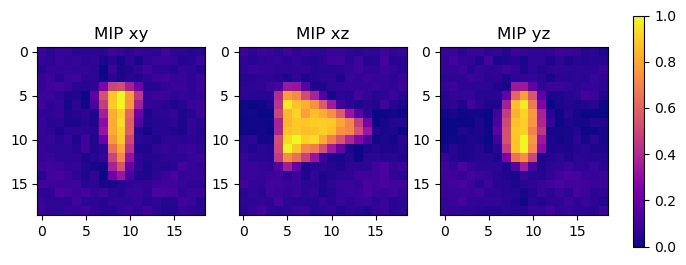

In [112]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

im1 = axes[0].imshow(Ixy_1, cmap="plasma", vmin=0,vmax=1)
axes[0].set_title("MIP xy")
im2 = axes[1].imshow(Ixz_1, cmap="plasma", vmin=0,vmax=1)
axes[1].set_title("MIP xz")
im3 = axes[2].imshow(Iyz_1, cmap="plasma", vmin=0,vmax=1)
axes[2].set_title("MIP yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

5.565827330549055e-06 -0.0
6.1467599510744934e-06 -0.0
5.565827330549055e-06 -0.0


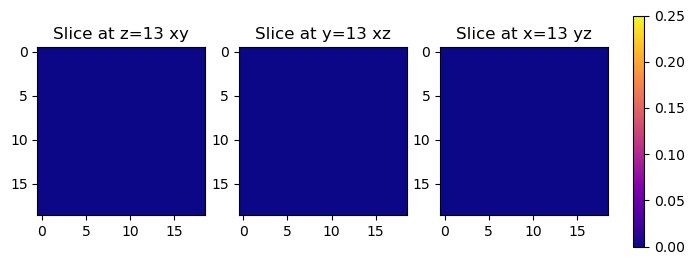

In [113]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

print(np.max(reshape_xy_1[9,:,:]),np.min(reshape_xy_1[9,:,:]))
print(np.max(reshape_xz_1[9,:,:]),np.min(reshape_xz_1[9,:,:]))
print(np.max(reshape_yz_1[9,:,:]),np.min(reshape_yz_1[9,:,:]))

im1 = axes[0].imshow(reshape_xy_1[9,:,:].transpose(), cmap="plasma", vmin=0,vmax=0.25)
axes[0].set_title("Slice at z=13 xy")
im2 = axes[1].imshow(reshape_xz_1[9,:,:], cmap="plasma", vmin=0,vmax=0.25)
axes[1].set_title("Slice at y=13 xz")
im3 = axes[2].imshow(reshape_yz_1[9,:,:], cmap="plasma", vmin=0,vmax=0.25)
axes[2].set_title("Slice at x=13 yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

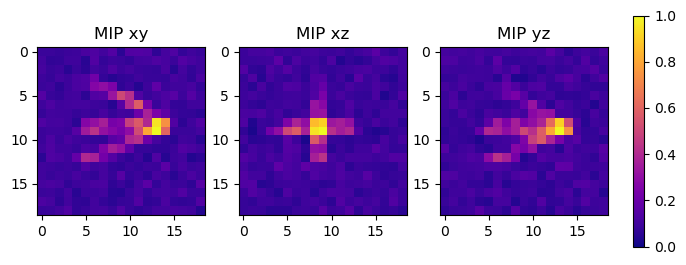

In [59]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

im1 = axes[0].imshow(Ixy_2,cmap="plasma",vmin=0,vmax=1)
axes[0].set_title("MIP xy")
im2 = axes[1].imshow(Ixz_2,vmin=0,cmap="plasma",vmax=1)
axes[1].set_title("MIP xz")
im3 = axes[2].imshow(Iyz_2,vmin=0,cmap="plasma",vmax=1)
axes[2].set_title("MIP yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

0.1576463144418767 -0.0
0.05084602587218523 -0.0
0.1576463144418767 -0.0


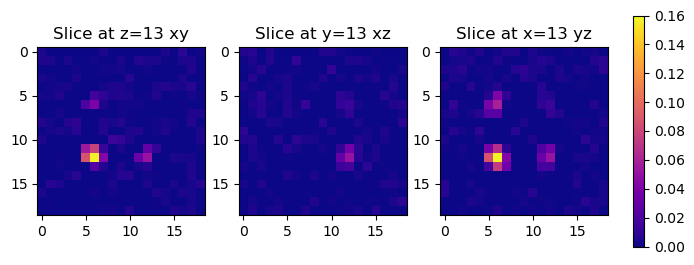

In [84]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

print(np.max(reshape_xy_2[12,:,:]),np.min(reshape_xy_2[12,:,:]))
print(np.max(reshape_xz_2[12,:,:]),np.min(reshape_xz_2[12,:,:]))
print(np.max(reshape_yz_2[12,:,:]),np.min(reshape_yz_2[12,:,:]))

im1 = axes[0].imshow(reshape_xy_2[12,:,:].transpose(), cmap="plasma", vmin=0,vmax=0.16)
axes[0].set_title("Slice at z=13 xy")
im2 = axes[1].imshow(reshape_xz_2[12,:,:], cmap="plasma", vmin=0,vmax=0.16)
axes[1].set_title("Slice at y=13 xz")
im3 = axes[2].imshow(reshape_yz_2[12,:,:], cmap="plasma", vmin=0,vmax=0.16)
axes[2].set_title("Slice at x=13 yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

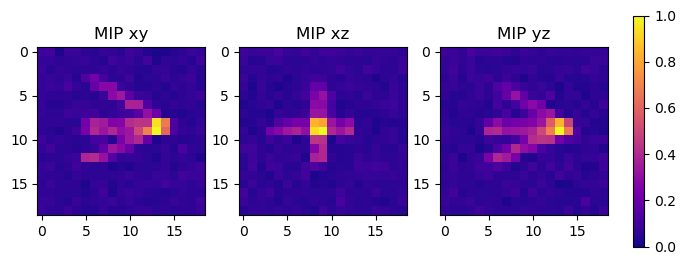

In [63]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

im1 = axes[0].imshow(Ixy_3, cmap="plasma", vmin=0,vmax=1)
axes[0].set_title("MIP xy")
im2 = axes[1].imshow(Ixz_3, cmap="plasma", vmin=0,vmax=1)
axes[1].set_title("MIP xz")
im3 = axes[2].imshow(Iyz_3, cmap="plasma", vmin=0,vmax=1)
axes[2].set_title("MIP yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

0.18220062093134715 -0.0
0.06038846112230978 -0.0
0.18220062093134715 -0.0


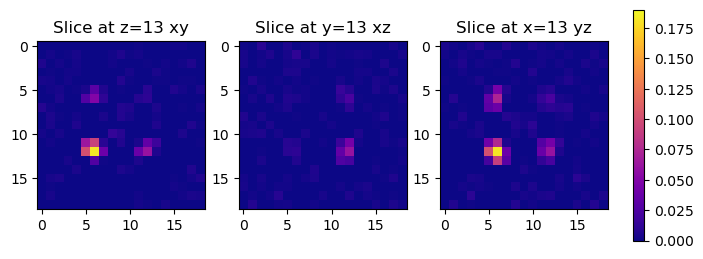

In [87]:

fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

print(np.max(reshape_xy_3[12,:,:]),np.min(reshape_xy_3[12,:,:]))
print(np.max(reshape_xz_3[12,:,:]),np.min(reshape_xz_3[12,:,:]))
print(np.max(reshape_yz_3[12,:,:]),np.min(reshape_yz_3[12,:,:]))

im1 = axes[0].imshow(reshape_xy_3[12,:,:].transpose(), cmap="plasma", vmin=0,vmax=0.19)
axes[0].set_title("Slice at z=13 xy")
im2 = axes[1].imshow(reshape_xz_3[12,:,:], cmap="plasma", vmin=0,vmax=0.19)
axes[1].set_title("Slice at y=13 xz")
im3 = axes[2].imshow(reshape_yz_3[12,:,:], cmap="plasma", vmin=0,vmax=0.19)
axes[2].set_title("Slice at x=13 yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

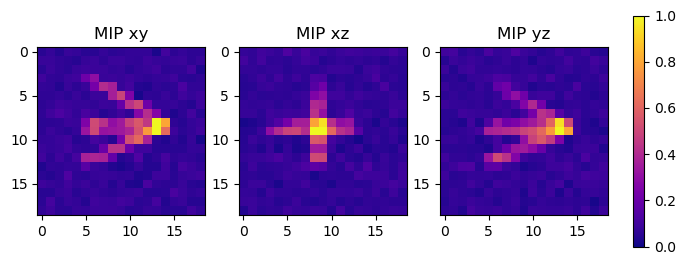

In [14]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

im1 = axes[0].imshow(Ixy_4, cmap="plasma", vmin=0,vmax=1)
axes[0].set_title("MIP xy")
im2 = axes[1].imshow(Ixz_4, cmap="plasma", vmin=0,vmax=1)
axes[1].set_title("MIP xz")
im3 = axes[2].imshow(Iyz_4, cmap="plasma", vmin=0,vmax=1)
axes[2].set_title("MIP yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

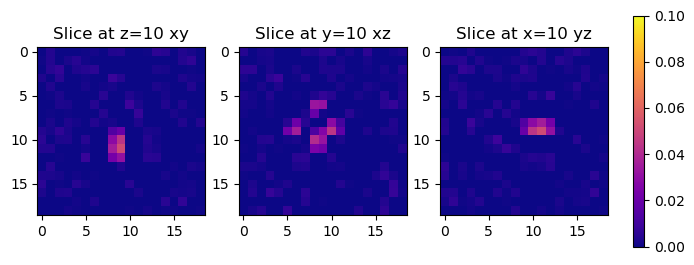

In [15]:
fig, axes = plt.subplots(1,3,figsize = (8,3))
axes = axes.flatten()

im1 = axes[0].imshow(reshape_xy_4[10,:,:], cmap="plasma", vmin=0,vmax=0.1)
axes[0].set_title("Slice at z=10 xy")
im2 = axes[1].imshow(reshape_xz_4[10,:,:], cmap="plasma", vmin=0,vmax=0.1)
axes[1].set_title("Slice at y=10 xz")
im3 = axes[2].imshow(reshape_yz_4[10,:,:], cmap="plasma", vmin=0,vmax=0.1)
axes[2].set_title("Slice at x=10 yz")

cbar = fig.colorbar(im3,ax=axes,orientation = 'vertical',fraction = 0.04,pad=0.04)

plt.show()

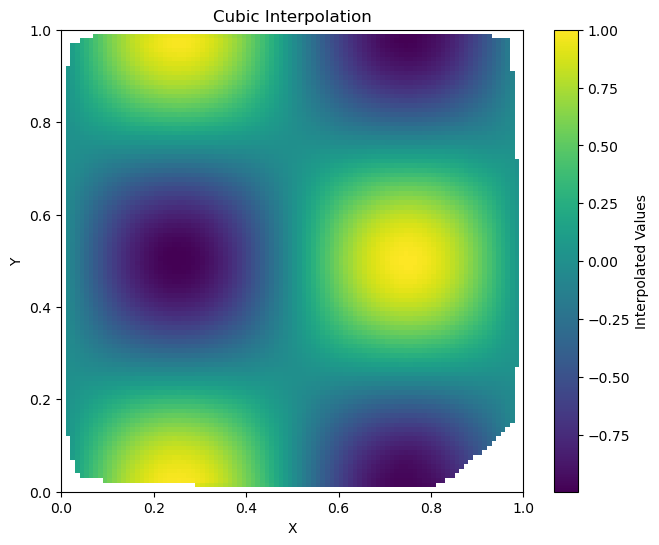

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 生成示例散点数据
np.random.seed(42)
points = np.random.rand(500, 2)  # 500个二维点
values = np.sin(2 * np.pi * points[:, 0]) * np.cos(2 * np.pi * points[:, 1])  # 示例值

# 定义目标网格
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# 选择插值方法
method = 'cubic'  # 可尝试 'nearest', 'linear', 'cubic'

# 执行插值
grid_z = griddata(points, values, (grid_x, grid_y), method=method, fill_value=np.nan)

# 绘制结果
plt.figure(figsize=(8, 6))
plt.imshow(grid_z.T, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Values')
plt.title(f'{method.capitalize()} Interpolation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

⚠️ 警告：系统矩阵范数太小，可能存在数值不稳定风险。


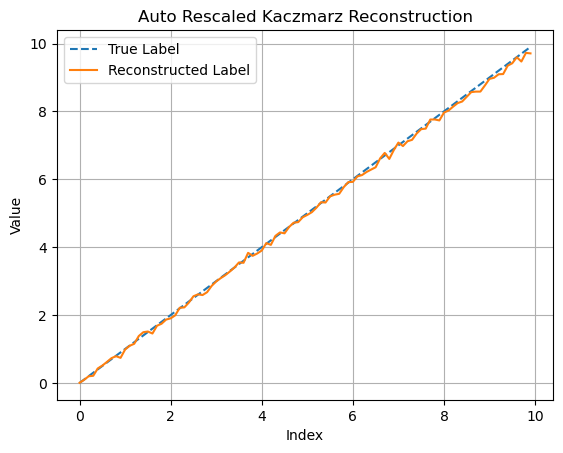

重建误差: 8.5462e-01


In [1]:
import numpy as np
from matplotlib import pyplot as plt

class Weight_Matrix:
    def __init__(self, A):
        self.energy = self.row_energy(A)
        self.Matrix_size = A.shape[0]

    def row_energy(self, A):
        M = A.shape[0]
        energy = np.zeros(M, dtype=np.double)
        for m in range(M):
            energy[m] = np.linalg.norm(A[m, :])
        return energy

def Kaczmarz_origin(A, b, weight_matrix, Lambda, is_Shuffle):
    energy = weight_matrix.energy
    M, N = A.shape
    x = np.zeros(N, dtype=np.complex128)
    v = np.zeros(M, dtype=np.complex128)
    rowIndexCycle = np.arange(M)
    if is_Shuffle:
        np.random.shuffle(rowIndexCycle)

    for i in range(10):
        for j in range(M):
            k = rowIndexCycle[j]
            alpha = (b[0][k] - np.dot(A[k, :], x) - np.sqrt(Lambda) * v[k]) / (energy[k] ** 2 + Lambda)
            x += alpha * A[k, :].conjugate()
            v[k] += alpha * np.sqrt(Lambda)

    x.imag = 0
    x = x * (x.real > 0)
    return x

# ----------- 自动缩放函数 -----------
def auto_rescale_and_reconstruct(SM, data, label, Lambda=0.01, is_Shuffle=False):
    # 估计放大因子：让最大范数变为 ~1
    row_norms = np.linalg.norm(SM, axis=1)
    max_norm = np.max(row_norms)
    if max_norm < 1e-12:
        print("⚠️ 警告：系统矩阵范数太小，可能存在数值不稳定风险。")

    scale_factor = 1.0 / max_norm

    # 缩放
    SM_scaled = SM * scale_factor
    data_scaled = data * scale_factor

    # 重建
    weight_matrix = Weight_Matrix(SM_scaled)
    recon_label_scaled = Kaczmarz_origin(SM_scaled, data_scaled, weight_matrix, Lambda, is_Shuffle)

    # 因为数据和矩阵同时缩放了，x 不需要缩放，直接返回
    return recon_label_scaled.real

# ----------- 模拟数据 -----------
np.random.seed(42)
label = np.arange(100) * 0.1

# 生成 e-23 级别系统矩阵
SM_1 = np.random.randn(200, 100) * 1e-23
SM_2 = np.random.randn(200, 100) * 1e-23
SM = SM_1 + 1j * SM_2

data = SM @ label.reshape(-1, 1)
data = data.reshape(1, -1)

# 自动归一化并重建
recon_label = auto_rescale_and_reconstruct(SM, data, label)

# ----------- 可视化比较 -----------
plt.plot(label, label, label='True Label', linestyle='--')
plt.plot(label, recon_label, label='Reconstructed Label')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Auto Rescaled Kaczmarz Reconstruction")
plt.legend()
plt.grid(True)
plt.show()

# 打印误差
error = np.linalg.norm(label - recon_label)
print(f"重建误差: {error:.4e}")



scale: 795774.7154594767
m: 1.1309733552923252e-17
identity concentration: 0.0008809639272218277
beta 0.0035114712677410537


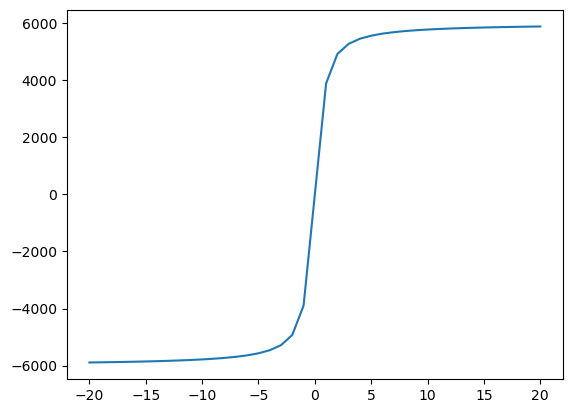

max m: 7.5398223686155035


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

diameter = 30e-9
volume = np.pi / 6 * (diameter**3)
saturation = 8e5 #2e11 
m = saturation * volume
u0 = 4.0 * np.pi *1e-7

scale = 1/u0
print("scale:",scale)

kb = 1.3806488e-23
t = 293.15  #310
beta = u0 * m / (kb * t)

mol = 6.022e23
ms = 6e3


print("m:",m)
print("identity concentration:",ms / m / mol )
print("beta",beta)



def f(x):
    y = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] == 0:
            y[i] = 0
        else:
            y[i] =  ms * (1 / np.tanh(scale*beta*x[i]*1e-3) - 1 / (scale*beta*x[i]*1e-3))
    return y

_,axes = plt.subplots(1,1)
x = np.linspace(-20,20,41)
axes.plot(x,f(x))
plt.show()
#此时跟mol是无关的

print("max m:",6000 / scale * 1000) #7.54 较小于本身磁场

